In [1]:
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
import json
from tensorflow_addons.callbacks import TQDMProgressBar
import matplotlib.pyplot as plt
import ast
from tqdm.notebook import tqdm
from focal_loss import BinaryFocalLoss

In [2]:
def history_plot(*args, metric='loss'):
    if len(args) > 1:
        sum_list = []
        for x in args:
            sum_list += x.history[metric]
        val_sum_list = []
        for x in args:
            val_sum_list += x.history['val_' + metric]
        plt.plot(sum_list)
        plt.plot(val_sum_list)
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
    else:
        history = args[0]
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()

In [3]:
def to_one_hot_drop(comp_list):
    X_out = np.zeros((len(comp_list)*5, 745))
    y_out = np.zeros((len(comp_list)*5, 149))
    for i, x in tqdm(enumerate(comp_list)):
        array = label_binarize(x, classes=range(149)).flatten()
        for drop_i in range(5):
            y_out[i*5 + drop_i] = array[drop_i*149:(drop_i+1)*149]
            X_out[i*5 + drop_i] = array
            X_out[i*5 + drop_i, drop_i*149:(drop_i+1)*149] = 0
    return X_out, y_out

In [4]:
def get_top_5_ch(array):
    return [champion_index[np.argmax(sub_array)] for sub_array in np.split(array, 5)]

In [5]:
def get_top_5(array):
    return [np.argmax(sub_array) for sub_array in np.split(array, 5)]

In [6]:
def model_eval(test, test_hat):
    test_id = get_top_5(test)
    print('Test composition: '+str(get_top_5_ch(test)))
    print('Predicted composition: '+str(get_top_5_ch(test_hat)))

    error = [np.argwhere(np.sort(sub_array)[::-1] == sub_array[test_id[i]])[0][0] for i, sub_array in enumerate(np.split(test_hat, 5))]
    print('Predicted rank of test champions: '+str(error))

In [7]:
def rank_eval(y_test, y_test_hat):
    y_hat_rank = [np.argwhere(np.sort(y_test_hat[i])[::-1] == y_test_hat[i,np.argmax(y_test[i])])[0][0] for i in range(len(y_test))]

    print('Average prediction rank: ' + str(np.mean(y_hat_rank)))

    print('No. of correct predictions: ' + str(y_hat_rank.count(0)))

In [42]:
def rank_distribution(y_test, y_test_hat):
    y_hat_rank = [np.argwhere(np.sort(y_test_hat[i])[::-1] == y_test_hat[i,np.argmax(y_test[i])])[0][0] for i in range(len(y_test))]
    fig, ax = plt.subplots(figsize=(18,5))
    pd.Series(y_hat_rank).value_counts().plot(ax=ax, kind='bar')

In [76]:
def rank_avg_per_champ(y_test, y_test_hat):
    y_hat_rank = [np.argwhere(np.sort(y_test_hat[i])[::-1] == y_test_hat[i,np.argmax(y_test[i])])[0][0] for i in range(len(y_test))]
    y_test_champ = [inv_champion_dict[x] for x in np.argmax(y_test, axis=1)]
    df = pd.DataFrame({'rank':y_hat_rank, 'champ':y_test_champ})
    fig, ax = plt.subplots(figsize=(18,5))
    ax2 = ax.twinx()
    print(df.champ.value_counts().reset_index().head())
    print(df.groupby('champ').mean().head())
    print(pd.merge(df.groupby('champ').mean(), df.champ.value_counts().reset_index(), left_on='champ', right_on='index').head())
    pd.merge(df.groupby('champ').mean(), df.champ.value_counts().reset_index(), left_on='champ', right_on='index').sort_values('rank').plot(ax=ax, kind='bar', x='index', y=['champ', 'rank'])
    

In [8]:
def rank(y_test,y_test_hat):
    return np.argwhere(np.sort(y_test_hat)[::-1] == y_test_hat[np.argmax(y_test)])[0][0]

In [9]:
champion_index = list(pd.read_csv('processed_data/chamion_index.csv', index_col=0).values.flatten())

champion_dict = {y:i for i,y in enumerate(champion_index)}

df = pd.read_csv('processed_data/esports_data.csv')

df.champions = df.champions.apply(lambda x: ast.literal_eval(x))

df['champion_ids'] = df.champions.apply(lambda x: [champion_dict[y] for y in x])

df = df.drop_duplicates(subset=['team', 'id', 'win']).copy()

In [10]:
inv_champion_dict = {v:k for k,v in champion_dict.items()}

In [20]:
df_champ_expanded = pd.DataFrame.from_records(df.champions.values, columns=['TOP', 'JUNGLE', 'MIDDLE', 'BOTTOM', 'SUPPORT'])

df_champ_counts = df_champ_expanded.apply(lambda x :x.value_counts())

In [11]:
X, y = to_one_hot_drop(list(df.champion_ids))

In [12]:
X.shape

(46610, 745)

In [13]:
y.shape

(46610, 149)

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=100)

### New Architecture 

In [14]:
CBoW = tf.keras.Sequential()

CBoW.add(tf.keras.layers.Dense(32, activation='relu', input_shape=(745,)))
CBoW.add(tf.keras.layers.Dense(24, activation='relu'))
CBoW.add(tf.keras.layers.Dense(149, activation='softmax'))

In [16]:
CBoW.compile(loss=BinaryFocalLoss(gamma=2), optimizer='adadelta', metrics=['mae', 'mse'])

In [17]:
tqdm_callback = TQDMProgressBar(show_epoch_progress=False)

### Clash model, new data

In [28]:
CBoW = tf.keras.models.load_model('/Users/foleyc/projects/LoL-team-embedding/saved_models/CBoW_focal_loss_240000')

In [29]:
CBoW.evaluate(X_test, y_test)

146/146 [==============================] - 0s 646us/step - loss: 0.0223 - mean_absolute_error: 0.0126 - mean_squared_error: 0.0063


[0.02234480157494545, 0.012607824057340622, 0.006346486508846283]

In [79]:
history8 = CBoW.fit(X_train, y_train,
                    epochs=1000,
                    batch_size=8,
                    shuffle=True,
                    verbose=0,
                    validation_data=(X_test, y_test),
                    callbacks=[tqdm_callback])

In [80]:
CBoW.evaluate(X_test, y_test)

146/146 [==============================] - 0s 759us/step - loss: 0.0174 - mean_absolute_error: 0.0122 - mean_squared_error: 0.0060


[0.017446255311369896, 0.012173544615507126, 0.006015381310135126]

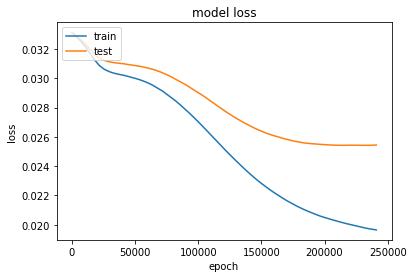

In [102]:
history_plot(history1, history2, history3, history4, history5, history6)

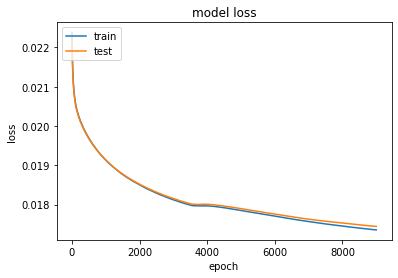

In [81]:
history_plot(history7, history8)

In [78]:
CBoW.save('saved_models/CBoW_focal_loss_w_esports_000')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: saved_models/CBoW_focal_loss_w_esports_8000/assets


In [82]:
y_test_hat = CBoW.predict(X_test)

In [83]:
rank_eval(y_test, y_test_hat)

Average prediction rank: 8.118214975327183
No. of correct predictions: 929


      index  champ
0  Aphelios    225
1  Nautilus    187
2    Thresh    151
3    Ezreal    150
4      Sett    149
               rank
champ              
Aatrox     2.026316
Ahri      67.000000
Akali     20.956522
Alistar   24.833333
Aphelios   0.728889
        rank     index  champ
0   2.026316    Aatrox    114
1  67.000000      Ahri      1
2  20.956522     Akali     23
3  24.833333   Alistar     12
4   0.728889  Aphelios    225


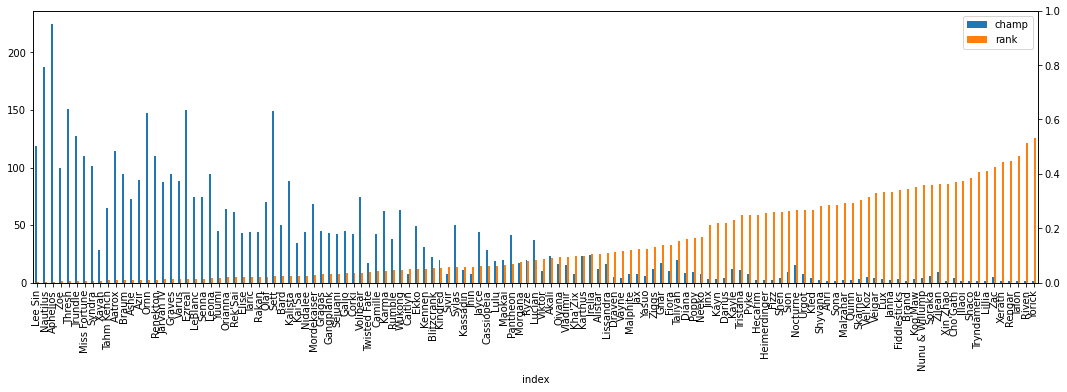

In [84]:
rank_avg_per_champ(y_test, y_test_hat)

In [47]:
y_test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

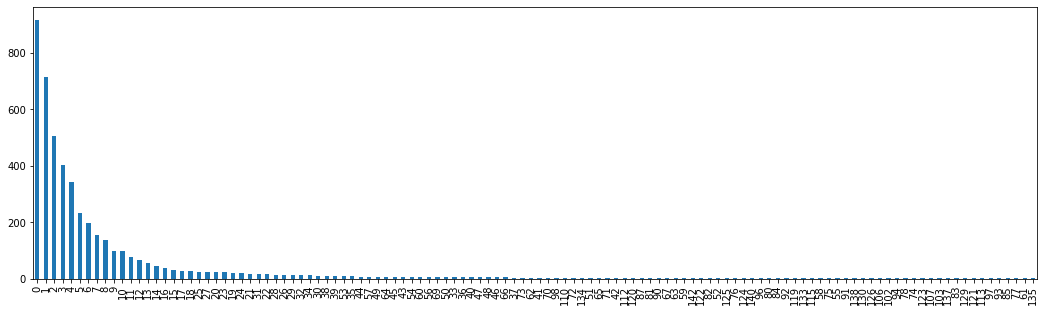

In [43]:
rank_distribution(y_test, y_test_hat)

In [15]:
CBoW.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                23872     
_________________________________________________________________
dense_1 (Dense)              (None, 24)                792       
_________________________________________________________________
dense_2 (Dense)              (None, 149)               3725      
Total params: 28,389
Trainable params: 28,389
Non-trainable params: 0
_________________________________________________________________


In [97]:
np.argmax(y_test_hat, axis=1)

array([ 43,   7, 102,  50,  85,  62,  86, 101,   7,  27, 114, 114,  62,
        79,  85,  24,  43,  86,   7,  62, 101,  86,  43,  67,  14,  67,
       102,  63, 142, 120, 142,  86,   7, 102, 128,   7,  62, 102, 114,
       114,  43, 102, 102, 140,  43,  50,  27,  62, 102,  86, 102,  62,
        67, 102, 113, 114, 101,  63,  27,  62, 113,  86,  14, 114,  27,
        86,  63,  43,  36,  73, 114, 101,  62,  86, 101,  43,  24,  62,
        79,  86,  86,   7,  24,  62, 114,  86, 120, 135,  67, 142,  84,
        67, 120,   7,  50,  48,  50, 142,  73,   7,  86, 142,  63, 114,
        86,  36,   0,  62, 102, 120, 122, 114, 102, 142,  86,  86, 102,
        36, 102, 113, 142, 122, 142, 102, 122,  62,   7, 114,  73,   7,
        86,  73,  27,  86,  50, 102, 114,  27,  43,  43, 114, 142, 114,
       101,   7, 114,  36,  62,   7,  86,   7,  85,  27,  43, 102,  63,
        43,  36, 101, 120,  43,  86,  86, 102, 120,  86, 120, 102,  36,
        62,  36,   7, 114, 120, 142,  36, 120, 114,  86,  86,  2

In [106]:
np.argmax(y_test_hat, axis=1)

array([ 43,   7,   0, 114,  85,  84,   0, 101,   7,  27, 114, 114,  24,
        79, 114,  24,  43,  86,   7,  62, 101,  86,  43,  67,  14,  67,
       102,  25, 142, 120,  35, 135,   7, 135, 128,  60,  62, 102, 114,
       114,  79,  71, 102, 140,  84,  50,  27, 122,  86,  86,  71,  62,
        67, 114, 114, 114, 142,  76,  27,   0, 113,  86,  14, 114,  27,
        86,  63,  36,  36,  15, 114, 101,  62,  86, 101, 122,  24,  24,
        79,  86,  86,   7,  24, 102, 114,  86, 102, 122,  67, 142,  84,
        67, 120,  15,  50,  48,  50,  43,  73,   7,  71, 142,  14, 114,
       135,  36,  75,  84,  74, 120, 122, 114, 102, 142, 102,  86, 102,
       122, 113, 135,  50, 122, 142, 102, 122,  62,   7, 114,  73,   7,
        74, 128,  27,  86,  50, 102, 114,  27,  43,  25, 114, 142, 113,
        15,  15, 114,  36,  62,   7,  74,   7,  85,  27,  43, 135,  14,
        43,  36, 120, 142,  43,  86,  86, 102,  14,  86,  14,  84,  36,
       135,  36,   7,  85, 120, 142,  36, 120, 114,  86,  86,  2

In [108]:
len([inv_champion_dict[x] for x in np.unique(np.argmax(y_test_hat, axis=1))])

42

In [109]:
len(Out[98])

31

In [98]:
[inv_champion_dict[x] for x in np.unique(np.argmax(y_test_hat, axis=1))]

['Aatrox',
 'Aphelios',
 'Braum',
 'Ekko',
 'Elise',
 'Ezreal',
 'Graves',
 'Jarvan IV',
 "Kai'Sa",
 'Karma',
 'Lee Sin',
 'Leona',
 'Lulu',
 'Miss Fortune',
 'Mordekaiser',
 'Nautilus',
 'Olaf',
 'Orianna',
 'Ornn',
 'Senna',
 'Sett',
 'Sylas',
 'Syndra',
 'Thresh',
 'Trundle',
 'Varus',
 'Vayne',
 'Volibear',
 'Xayah',
 'Yasuo',
 'Yuumi']

In [27]:
y_test_hat

array([[0.00694902, 0.00671477, 0.00634038, ..., 0.00641056, 0.00679828,
        0.00644571],
       [0.00688413, 0.006406  , 0.00653308, ..., 0.00660546, 0.00669175,
        0.00657911],
       [0.00693451, 0.00667581, 0.00663656, ..., 0.00620386, 0.00646717,
        0.00636737],
       ...,
       [0.00688245, 0.00653517, 0.00657387, ..., 0.00648784, 0.0067426 ,
        0.00667167],
       [0.00703866, 0.0069394 , 0.00653902, ..., 0.00669036, 0.0063172 ,
        0.00652657],
       [0.00702228, 0.00675653, 0.00682039, ..., 0.00643201, 0.00640932,
        0.00662966]], dtype=float32)